# **Promotor sequence recognition**

1. Read in fasta files - done
2. Preprocess data
3. Build model
4. Test and iterate

In [1]:
# libraries
library(tidyverse) # metapackage of all tidyverse packages
library(keras)
library(tensorflow)
library(tokenizers) # or vectorization??
library(seqinr)  # for fasta files
library(reticulate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘seqinr’


The following object is masked from ‘package:dplyr’:

    count




# Data downloading and transformation from fasta to txt format

In [2]:
# read.fasta https://www.rdocumentation.org/packages/seqinr/versions/4.2-4/topics/read.fasta

In [3]:
# read fasta files to directories
#url <- "https://raw.githubusercontent.com/simecek/dspracticum2020/master/lecture_08/assignment/e_coli_promoters/"
#datasets <- c("train", "valid")
#sets <- c("nonpromoters", "promoters")

#for(i in 1:length(datasets)){
    # create train or validation directory
#    dir.create(paste('../', datasets[i], sep = ''))
#    for(j in 1:length(sets)){
        # create promoter or nonpromoter directory
#        dir.name <- paste('../', datasets[i], '/', sets[j], sep = '')
#        dir.create(dir.name)
        # path to the fasta file
#        path <- paste(url, 'e_coli_', sets[j], '_', datasets[i], '.fa', sep = '')
        # read fasta file
#        x <- read.fasta(url(path))
        
#        for (k in 1:length(x)){
            # create file for one sequence
#            fileConn <- file(paste(dir.name, '/', getName(x[k]), '.txt', sep = ''))
            # save the sequence to the file
#            getSequence(x[[k]], as.string = T) %>% unlist() %>%
#                writeLines(., fileConn)
#            close(fileConn)  # close file
#        }
#    }
#}



In [4]:
# alternative approach
# read fasta files to dataframe

url <- "https://raw.githubusercontent.com/simecek/dspracticum2020/master/lecture_08/assignment/e_coli_promoters/"
sets <- c("nonpromoters", "promoters")

train_set <- c()
label_train <- c()
validation_set <- c()
label_validation <- c()

# preparation of train set
for (j in 1:length(sets)){
    # read fasta file
    path <- paste(url, 'e_coli_', sets[j], '_train.fa', sep = '')
    x <- read.fasta(url(path))
    for (k in 1:length(x)){
        # save the sequence
        train_set <- c(train_set, paste(x[[k]], collapse = " "))
        # save the label(promoter/non-promoter)
        label_train <- c(label_train, sets[j])
    }
}

# preparation of validation set
for (j in 1:length(sets)){
    # read fasta file
    path <- paste(url, 'e_coli_', sets[j], '_valid.fa', sep = '')
    x <- read.fasta(url(path))
    for (k in 1:length(x)){
        # save the sequence
        validation_set <- c(validation_set, paste(x[[k]], collapse = " "))
        # save the label(promoter/non-promoter)
        label_validation <- c(label_validation, sets[j])
    }
}

# convert both datasets to dataframes
options(stringsAsFactors = FALSE)
train_data <- data.frame(x = train_set, y = label_train)
valid_data <- data.frame(x = validation_set, y = label_validation)

In [5]:
train_data$x %>% 
  strsplit(" ") %>% 
  sapply(length) %>% 
  summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    150     150     150     150     150     150 

In [6]:
num_words <- 4
max_length <- 150
text_vectorization <- layer_text_vectorization(
  max_tokens = num_words, 
  output_sequence_length = max_length,
  output_mode = "int"
)

text_vectorization %>% adapt(train_data$x)
#text_vectorization(train_data$x[1])

# z nejakeho dovodu nefunguje set_vocabulary(text_vectorization)
# ani get_vocabulary(text_vectorization)
# vypada ze jde o nejaky python problem komunikace pluginu https://github.com/tensorflow/tensorflow/pull/34529


In [7]:
text_vectorization(train_data$x)

tf.Tensor(
[[1 3 1 ... 3 1 1]
 [1 2 1 ... 2 3 2]
 [2 1 1 ... 3 2 2]
 ...
 [1 3 1 ... 1 2 2]
 [3 1 1 ... 1 2 2]
 [3 3 3 ... 3 1 1]], shape=(6791, 150), dtype=int64)

In [8]:
input <- layer_input(shape = c(1), dtype = 'string')

output <- input %>% 
  text_vectorization() %>% 
  #layer_lambda(f = function(x){text_one_hot(text = x, n = 5)})
  layer_embedding(input_dim = max_length, output_dim = 32) %>%
  bidirectional(layer_gru(units = 64, return_sequences = TRUE)) %>%
  bidirectional(layer_gru(units = 64, return_sequences = FALSE)) %>%
  layer_dense(units = 32, activation = "relu") %>%
  # layer_dropout(0.2) %>%
  # layer_global_average_pooling_1d() %>%
  layer_dense(units = 1, activation = "sigmoid")

model <- keras_model(input, output)

Model

In [9]:
# model types
## LSTM
## Conv1D
## bidirectional

In [10]:
## compile model
model %>% compile(
  optimizer = 'adam',#optimizer_adam(lr = 0.001),
  loss = 'binary_crossentropy', #BinaryCrossentropy(from_logits=True)
  metrics = list('accuracy') #BinaryAccuracy(threshold=0.0)
)

In [11]:
m_epochs = 20
m_batch_size = 256
history <- model %>% fit(
  train_data$x,
  as.numeric(train_data$y == "promoters"),
  epochs = m_epochs,
  batch_size = m_batch_size,
  #validation_split = 0.2,
  validation_data = list(valid_data$x, as.numeric(valid_data$y == "promoters")),
  verbose = 0,
)

In [12]:
summary(model)

Model: "functional_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 1)]                     0           
________________________________________________________________________________
text_vectorization (TextVectorizati (None, 150)                     0           
________________________________________________________________________________
embedding (Embedding)               (None, 150, 32)                 4800        
________________________________________________________________________________
bidirectional (Bidirectional)       (None, 150, 128)                37248       
________________________________________________________________________________
bidirectional_1 (Bidirectional)     (None, 128)                     74112       
________________________________________________________________________________
dense 


Final epoch (plot to see history):
        loss: 0.4225
    accuracy: 0.8114
    val_loss: 0.4264
val_accuracy: 0.8147 

`geom_smooth()` using formula 'y ~ x'



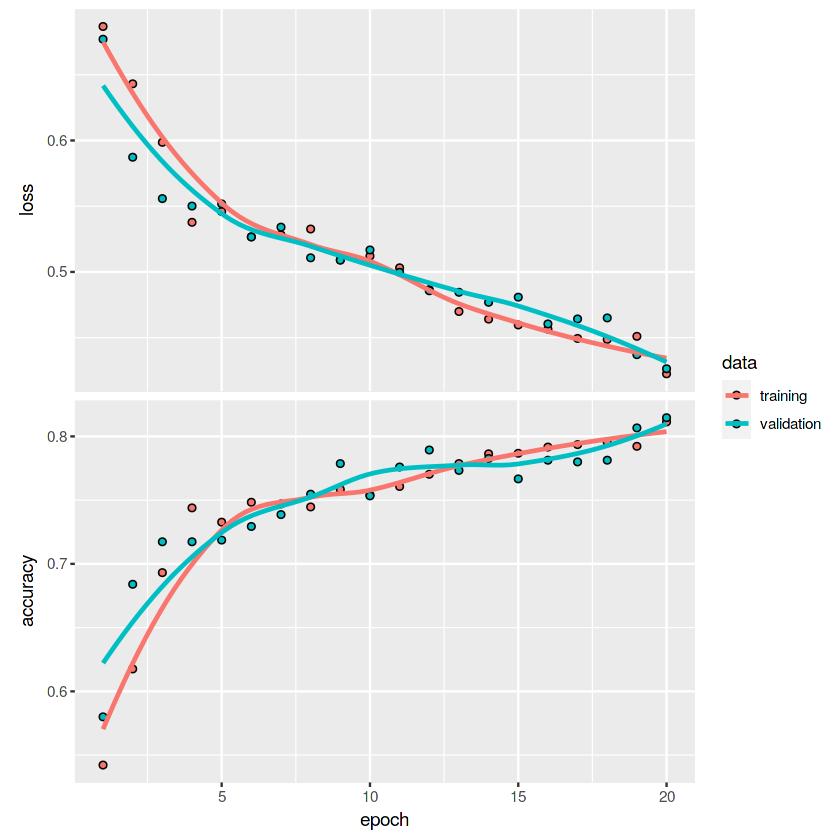

In [13]:
history
plot(history)

In [14]:
model %>% evaluate(
    train_data$x,
    as.numeric(train_data$y == "promoters"),
    verbose = 0
)

loss  accuracy 
0.4165649 0.8109262